In [27]:
from fastai.vision import *
from fastai.widgets import *

# Squash Classifier

I love winter squash. I typically hate summer squash. This classifier will help me make sure that I never accidentally purchas a zucchini squash when what I really want is an acorn squash.

In [16]:
types = ['butternut', 'pumpkin', 'acorn', 'zucchini', 'tromboncino']

In [17]:
# create directories for training data
for type in types:
    folder = type
    file = f'urls_{type}'
    path = Path('data/squash')
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

In [19]:
# make sure all my directories are in place
path.ls()

[PosixPath('data/squash/pumpkin'),
 PosixPath('data/squash/pumpkin.txt'),
 PosixPath('data/squash/tromboncino.txt'),
 PosixPath('data/squash/acorn.txt'),
 PosixPath('data/squash/tromboncino'),
 PosixPath('data/squash/acorn'),
 PosixPath('data/squash/butternut.txt'),
 PosixPath('data/squash/zucchini.txt'),
 PosixPath('data/squash/teddies.txt'),
 PosixPath('data/squash/zucchini'),
 PosixPath('data/squash/butternut')]

In [20]:
for type in types:
    download_images(path/f'{type}.txt', path/f'{type}/')

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

In [21]:
# verify all the URLs work and the images aren't broken:
for type in types:
    print(type)
    verify_images(path/type, delete=True, max_size=500)

butternut


pumpkin


acorn


zucchini


tromboncino


In [22]:
# Create ImageDataBunch. This will split data into train/valid/test 
np.random.seed(333)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,).normalize(imagenet_stats)

In [23]:
# Take a look at the classes in our ImageDataBunch. This should match the classes we made 
# file paths for. If not check previous steps.
data.classes

['acorn', 'butternut', 'pumpkin', 'tromboncino', 'zucchini']

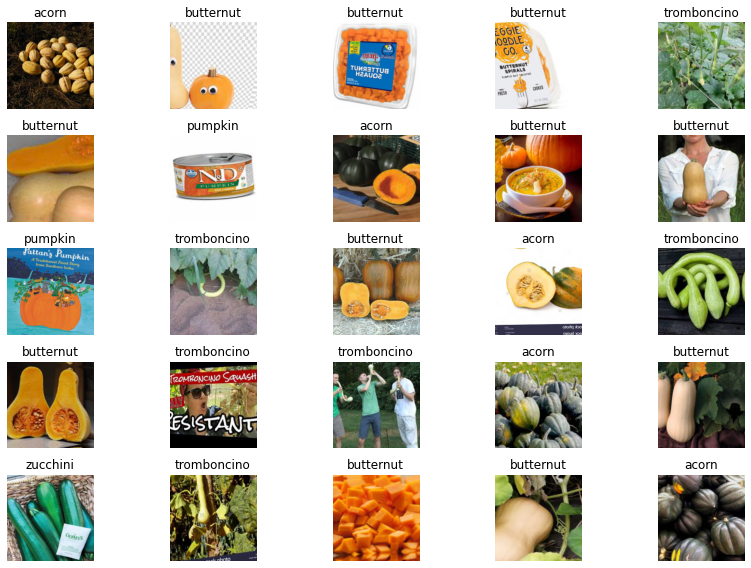

In [24]:
#Take a peek at our data.
data.show_batch(rows=5, figsize=(12,8))

In [25]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

In [26]:
# Train a model:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


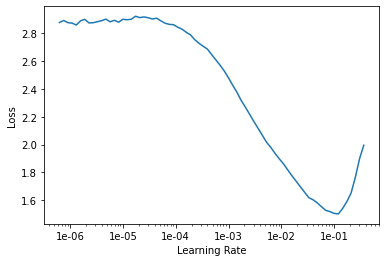

In [28]:
learner.recorder.plot()

In [29]:
learner.fit_one_cycle(4, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,1.554543,10.012287,0.375000,00:54
1,1.624382,4.801322,0.257812,00:54
2,1.716973,3.580875,0.226562,00:55
3,1.578165,2.312862,0.156250,00:54


In [30]:
learner.save('stage-1')

In [31]:
# Let's take a look at how our learner is doing:
interp = ClassificationInterpretation.from_learner(learner)

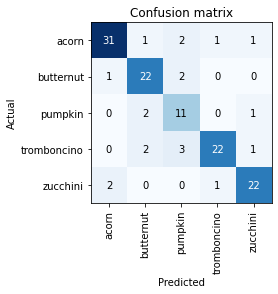

In [32]:
interp.plot_confusion_matrix()

# Cleaning Up

Let's take a look at our top losses. We are going to look for mislabeled data, or photos that aren't helpful (like pictures of butternut squash soup, which isn't going to be helpful for our model). 

In [35]:
# It's important to do the following steps on both the validation and the testing data-set

losses, idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [40]:
# create a combined dataset (no train/valid/test split) so that we can clean all the data at once:
db =(ImageList.from_folder(path)
        .split_none()
        .label_from_folder()
        .transform(get_transforms(), size=224)
        .databunch()
    )

In [42]:
# make a new cnn_learner for our combined data bunch (db):
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (640 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pumpkin,pumpkin,pumpkin,pumpkin,pumpkin
Path: data/squash;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/squash;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa